├── Images  
│   ├── Training  
│   |      └── normal  
│   |      └── potholes   
│   └── Validation    
│   |      └── normal    
│   |      └── potholes    
└── README.md  

https://www.kaggle.com/pradneshmhatre/pothole-detector-with-keras

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.math import tanh, softplus
from tensorflow.math import sigmoid
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


def resize_image(image_path, image_size):   
    img = cv2.imread(image_path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (image_size, image_size))
    return np.array(img)


def prepare_data(image_size):
    
    image_paths = [os.path.join(root, file) 
                   for root, _, files in os.walk(os.path.abspath("Images/")) 
                   for file in files]

    X_train, X_test, y_train, y_test = [], [], [], []

    for image_path in image_paths:
        try:
            img = resize_image(image_path, image_size)

            if "Training" in image_path:
                X_train.append(img)

                if "potholes" in image_path:
                    y_train.append("Pothole")
                else:
                    y_train.append("Normal")

            elif "Validation" in image_path:
                X_test.append(img)

                if "potholes" in image_path:
                    y_test.append("Pothole")
                else:
                    y_test.append("Normal")
        except Exception as e:
            pass

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    return X_train, X_test, y_train, y_test


def show_random_images():
    fig,ax=plt.subplots(2,5)
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
    fig.set_size_inches(15,15)

    for i in range(2):
        for j in range (5):
            l=randint(0,len(y_train))
            ax[i,j].imshow(X_train[l][:,:,::-1])
            ax[i,j].set_title(y_train[l])
            ax[i,j].set_aspect('equal')
            

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))


def mish(inputs):
    return inputs * tanh(softplus(inputs))


def create_model(activation, input_shape):
    # Create a CNN Sequential Model
    model = Sequential()

    model.add(Conv2D(32, (5,5), activation=activation, input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(64, (3, 3), activation=activation)) 
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation=activation)) 
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation=activation)) 
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation=activation)) 
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(128, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    
    return model


def create_generators(train_dir = 'Images/Training', test_dir = 'Images/Validation', target_size=(300, 300)):
    train_datagen = ImageDataGenerator()
    train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                        target_size=target_size,
                                                        batch_size=12,
                                                        class_mode='binary')

    validation_datagen = ImageDataGenerator()
    validation_generator = validation_datagen.flow_from_directory(directory=test_dir,
                                                                  target_size=target_size,
                                                                  batch_size=12,
                                                                  class_mode='binary')
    
    return train_generator, validation_generator

## Custom CNN - Relu vs. Mish vs. Gelu vs. Swish
Starting with mostly manual work to get a feeling for using these networks

**Prepare Data**

In [7]:
X_train, X_test, y_train, y_test = prepare_data(image_size=150)

**Display Data**

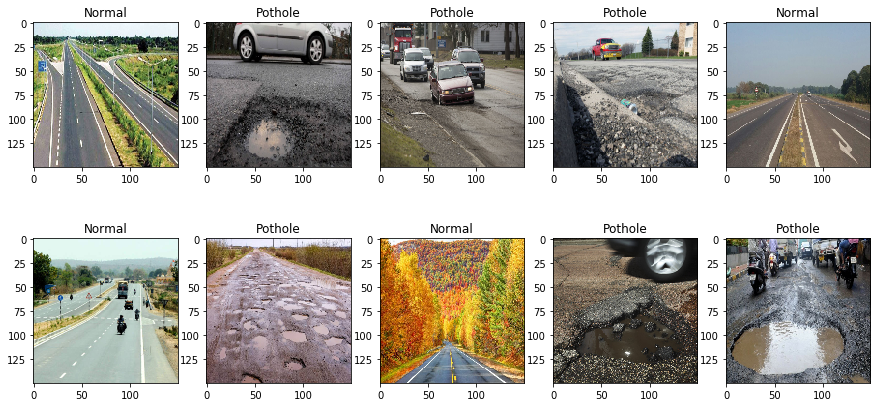

In [8]:
show_random_images()

**Split Data**

In [9]:
# Label encode y
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

**Models**

In [18]:
input_shape = X_train[0].shape

# Relu
model_relu = create_model('relu', input_shape)
model_relu.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Leaky
model_leaky = create_model(LeakyReLU(), input_shape)
model_leaky.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Swish
model_swish = create_model(swish, input_shape)
model_swish.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Mish
model_mish = create_model(mish, input_shape)
model_mish.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])


print(model_relu.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 146, 146, 32)      2432      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 128)      

**Fit all Models**

In [20]:
model_relu.fit(X_train, y_train, epochs=2, batch_size=12, validation_data=(X_test, y_test))
model_leaky.fit(X_train, y_train, epochs=2, batch_size=12, validation_data=(X_test, y_test))
model_swish.fit(X_train, y_train, epochs=2, batch_size=12, validation_data=(X_test, y_test))
model_mish.fit(X_train, y_train, epochs=2, batch_size=12, validation_data=(X_test, y_test))

Train on 580 samples, validate on 100 samples
Epoch 1/2
580/580 [==============================] - 11s 19ms/sample - loss: 0.7371 - acc: 0.5862 - val_loss: 0.6066 - val_acc: 0.7400
Epoch 2/2
580/580 [==============================] - 11s 18ms/sample - loss: 0.7539 - acc: 0.5293 - val_loss: 1.7995 - val_acc: 0.5000
Train on 580 samples, validate on 100 samples
Epoch 1/2
580/580 [==============================] - 12s 20ms/sample - loss: 43.6885 - acc: 0.5483 - val_loss: 3.8872 - val_acc: 0.5000
Epoch 2/2
580/580 [==============================] - 11s 19ms/sample - loss: 4.7938 - acc: 0.6379 - val_loss: 0.8943 - val_acc: 0.7400
Train on 580 samples, validate on 100 samples
Epoch 1/2
580/580 [==============================] - 13s 23ms/sample - loss: 4.7509 - acc: 0.5776 - val_loss: 0.7034 - val_acc: 0.5200
Epoch 2/2
580/580 [==============================] - 13s 22ms/sample - loss: 0.7061 - acc: 0.6328 - val_loss: 0.8653 - val_acc: 0.5200
Train on 580 samples, validate on 100 samples
Epoch

**Results**

In [25]:
for model, name in zip([model_relu, model_leaky, model_swish, model_mish], ["Relu", "Leaky Relu", "Swish", "Mish"]):
    print(name)
    loss, accuracy = model.evaluate(X_test, y_test)
    print('{} Test accuracy: {:2.2f}% \n'.format(name, accuracy*100))
    
    predictions = model.predict(X_test).reshape(1, -1)[0]
    predictions = [0 if val < 0.5 else 1 for val in predictions]
    print(confusion_matrix(predictions, y_test, labels=None, sample_weight=None, normalize=None))
    print()

Relu
100/100 [==============================] - 0s 4ms/sample - loss: 1.7995 - acc: 0.5000
Relu Test accuracy: 50.00% 

[[ 0  0]
 [50 50]]

Leaky Relu
100/100 [==============================] - 0s 4ms/sample - loss: 0.8943 - acc: 0.7400
Leaky Relu Test accuracy: 74.00% 

[[24  0]
 [26 50]]

Swish
100/100 [==============================] - 1s 5ms/sample - loss: 0.8653 - acc: 0.5200
Swish Test accuracy: 52.00% 

[[50 48]
 [ 0  2]]

Mish
100/100 [==============================] - 1s 6ms/sample - loss: 0.5996 - acc: 0.5400
Mish Test accuracy: 54.00% 

[[49 45]
 [ 1  5]]



## ImageGenerator - Relu vs. Mish vs. Gelu vs. Swish
To do a little more advanced preprocessing

In [26]:
target_size = (150, 150)
train_generator, validation_generator = create_generators(train_dir='Images/Training', 
                                                          test_dir='Images/Validation',
                                                          target_size=target_size)

Found 581 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [27]:
input_shape = (150, 150, 3)

# Relu
model_relu = create_model('relu', input_shape)
model_relu.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Leaky
model_leaky = create_model(LeakyReLU(), input_shape)
model_leaky.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Swish
model_swish = create_model(swish, input_shape)
model_swish.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Mish
model_mish = create_model(mish, input_shape)
model_mish.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])


print(model_relu.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 146, 146, 32)      2432      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 14, 14, 128)     

In [42]:
# model_relu = create_model('relu', input_shape)
# model_relu.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# print(model_relu.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 146, 146, 32)      2432      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 128)      

## Don't forget to normalize the input by dividing by 255
## also, set alpha for leaky

In [28]:
history = {}
for model, name in zip([model_relu, model_leaky, model_swish, model_mish], 
                       ["Relu", "Leaky Relu", "Swish", "Mish"]):

    history[name] = model.fit_generator(train_generator, 
                                       steps_per_epoch=50, # typically num_samples // batch_size
                                       epochs=30, 
                                       validation_data=validation_generator,
                                       validation_steps=50, # typically num_samples // batch_size
                                       verbose=1)

Epoch 1/30
50/50 [==============================] - 37s 730ms/step - loss: 2.6800 - acc: 0.5194 - val_loss: 0.6500 - val_acc: 0.7375
Epoch 2/30
50/50 [==============================] - 34s 681ms/step - loss: 0.9226 - acc: 0.5447 - val_loss: 0.6898 - val_acc: 0.5071
Epoch 3/30
50/50 [==============================] - 35s 708ms/step - loss: 0.7882 - acc: 0.5616 - val_loss: 0.6881 - val_acc: 0.5196
Epoch 4/30
50/50 [==============================] - 35s 696ms/step - loss: 0.6833 - acc: 0.6416 - val_loss: 0.6237 - val_acc: 0.6482
Epoch 5/30
50/50 [==============================] - 35s 695ms/step - loss: 0.9085 - acc: 0.7367 - val_loss: 0.9018 - val_acc: 0.5679
Epoch 6/30
50/50 [==============================] - 35s 691ms/step - loss: 0.5960 - acc: 0.7116 - val_loss: 2.4781 - val_acc: 0.5054
Epoch 7/30
50/50 [==============================] - 35s 694ms/step - loss: 0.7623 - acc: 0.7386 - val_loss: 0.5331 - val_acc: 0.7661
Epoch 8/30
50/50 [==============================] - 34s 686ms/step - 

Epoch 28/30
50/50 [==============================] - 35s 693ms/step - loss: 0.3503 - acc: 0.8500 - val_loss: 0.5618 - val_acc: 0.8321
Epoch 29/30
50/50 [==============================] - 35s 709ms/step - loss: 0.4418 - acc: 0.8584 - val_loss: 0.4871 - val_acc: 0.8357
Epoch 30/30
50/50 [==============================] - 36s 712ms/step - loss: 0.5349 - acc: 0.8735 - val_loss: 0.5683 - val_acc: 0.8250
Epoch 1/30
50/50 [==============================] - 37s 749ms/step - loss: 22.5429 - acc: 0.5599 - val_loss: 0.9807 - val_acc: 0.6321
Epoch 2/30
50/50 [==============================] - 34s 676ms/step - loss: 4.9397 - acc: 0.5599 - val_loss: 1.6689 - val_acc: 0.4625
Epoch 3/30
50/50 [==============================] - 34s 688ms/step - loss: 2.7110 - acc: 0.5649 - val_loss: 0.6410 - val_acc: 0.5411
Epoch 4/30
50/50 [==============================] - 35s 693ms/step - loss: 2.4282 - acc: 0.6138 - val_loss: 0.5095 - val_acc: 0.7732
Epoch 5/30
50/50 [==============================] - 34s 686ms/ste

Epoch 25/30
50/50 [==============================] - 34s 679ms/step - loss: 0.4622 - acc: 0.8685 - val_loss: 0.9671 - val_acc: 0.8286
Epoch 26/30
50/50 [==============================] - 35s 691ms/step - loss: 0.4738 - acc: 0.8823 - val_loss: 1.2968 - val_acc: 0.7429
Epoch 27/30
50/50 [==============================] - 34s 681ms/step - loss: 0.6242 - acc: 0.8634 - val_loss: 0.6094 - val_acc: 0.8714
Epoch 28/30
50/50 [==============================] - 36s 728ms/step - loss: 0.4997 - acc: 0.8817 - val_loss: 0.8660 - val_acc: 0.8018
Epoch 29/30
50/50 [==============================] - 35s 700ms/step - loss: 0.4655 - acc: 0.8853 - val_loss: 0.9566 - val_acc: 0.7804
Epoch 30/30
50/50 [==============================] - 35s 697ms/step - loss: 1.2182 - acc: 0.8600 - val_loss: 0.8734 - val_acc: 0.8143
Epoch 1/30
50/50 [==============================] - 39s 775ms/step - loss: 5.6301 - acc: 0.5245 - val_loss: 0.8011 - val_acc: 0.4964
Epoch 2/30
50/50 [==============================] - 37s 736ms/s

KeyboardInterrupt: 

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

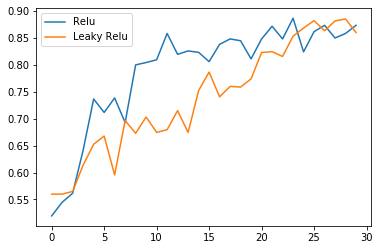

In [40]:
fig = plt.figure()
ax = plt.subplot(111)

acc_relu = history['Relu'].history['acc']
acc_leaky = history['Leaky Relu'].history['acc']

x = np.arange(0, len(acc_relu))
ax.plot(x, acc_relu, label='Relu')
ax.plot(x, acc_leaky, label='Leaky Relu')
ax.legend()

plt.show()

## EfficientNet
https://www.dlology.com/blog/transfer-learning-with-efficientnet/

In [18]:
from efficientnet.keras import EfficientNetB0 as Net
from keras import layers, models

In [19]:
# from efficientnet import EfficientNetB0 as Net
# from efficientnet import center_crop_and_resize, preprocess_input

# loading pretrained conv base model
input_shape = (150, 150, 3)
conv_base = Net(weights="imagenet", include_top=False, input_shape=input_shape)

In [20]:
conv_base.trainable = False

In [21]:
dropout_rate = 0.2
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
model.add(layers.Dense(1, activation="sigmoid", name="fc_out"))

In [22]:
target_size = (150, 150)
train_generator, validation_generator = create_generators(train_dir='Images/Training', 
                                                          test_dir='Images/Validation',
                                                          target_size=target_size)

Found 581 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [23]:
import keras

In [24]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(lr=2e-5),
    metrics=["acc"],
)

In [25]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=50, 
                              epochs=2, 
                              validation_data=validation_generator,
                              validation_steps=50,
                              verbose=1,    
                              use_multiprocessing=True,
                              workers=4)


Epoch 1/2
50/50 [==============================] - 30s 592ms/step - loss: 1.4759 - acc: 0.5346 - val_loss: 55.3999 - val_acc: 0.5304
Epoch 2/2
50/50 [==============================] - 29s 576ms/step - loss: 1.4116 - acc: 0.5649 - val_loss: 268.3104 - val_acc: 0.5380


In [26]:
image_paths = []
for root, dirs, files in os.walk(os.path.abspath("Images/")):
    for file in files:
        image_paths.append(os.path.join(root, file))

In [13]:
from tensorflow.keras.utils import plot_model
# plot_model(conv_base, to_file='conv_base.png', show_shapes=True)
from IPython.display import Image
# Image(filename='conv_base.png') 

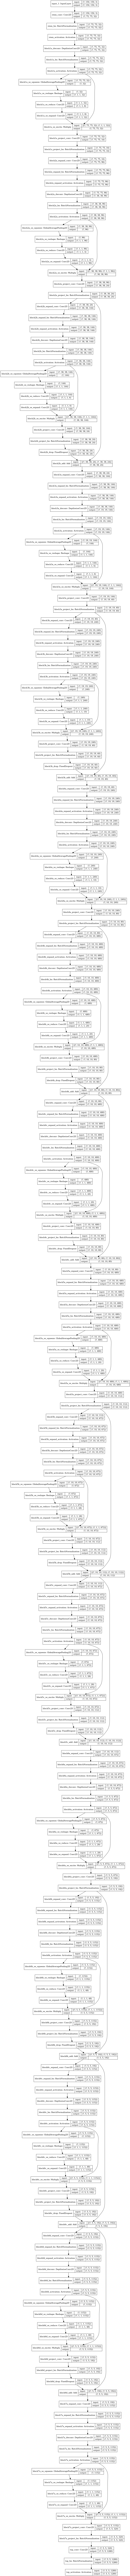

In [14]:
plot_model(conv_base, to_file='conv_base.png', show_shapes=True)


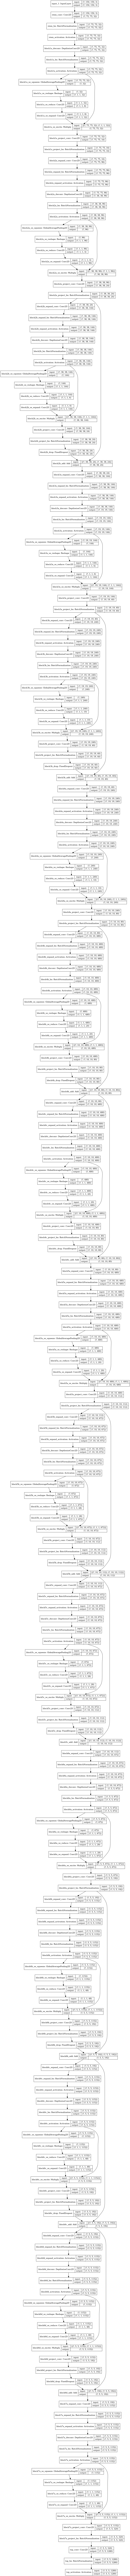

In [15]:
Image(filename='conv_base.png') 

In [17]:
for layer in conv_base.layers:
    print(layer.name)

input_1
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand
block3a_se_excite
block3a_project_conv
block3a_project_bn
block3b_expand_conv
block3b_expan